# Modelo Supervisado

Métodos: Logistic Regression, Decision Tree Classifier, XG Boost y Random Forest Classifier

Objetivo: Predecir la participación en el mercado laboral peruano por parte de mujeres en edad PEA. 

Características a ser evaluadas: edad, nivel de escolaridad, estado civil, cantidad de hijos, estado de salud y región geográfica de residencia. 

### Preparando datos

In [33]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings('ignore')

In [3]:
# librerías para el Modelamiento analítico

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from scipy import stats

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

from imblearn.over_sampling import SMOTE

#Abrir anaconda prompt con permisos de administrador
#conda install -c conda-forge imbalanced-learn
#conda install -c conda-forge scikit-learn
#cerrar jupyter notebook por completo y volver a abrirlo

In [34]:
df = pd.read_csv('C:/Users/Jose Pastor/Documents/GitHub/Jose_Pastor_r_py_jl/dataGitHub/ParticipacionLaboralFemenina_nomissingvalues.csv', encoding='latin-1')

In [35]:
df

,participa,edad,escolaridad,convcas,nninos,enfermedad,costa,sierra,selva
0,1.0,50,6.0,0,0,1.0,0,1,0
1,1.0,27,11.0,0,0,1.0,0,1,0
2,0.0,65,2.0,0,0,1.0,0,1,0
3,1.0,34,11.0,0,0,1.0,0,1,0
4,0.0,22,14.0,0,0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...
27069,1.0,29,14.0,0,0,1.0,1,0,0
27070,1.0,27,16.0,1,1,0.0,1,0,0
27071,1.0,28,14.0,0,1,0.0,1,0,0
27072,0.0,33,14.0,1,2,0.0,1,0,0


In [6]:
df.dtypes

participa      float64
edad             int64
escolaridad    float64
convcas          int64
nninos           int64
enfermedad     float64
costa            int64
sierra           int64
selva            int64
dtype: object

In [7]:
df.shape

(27074, 9)

In [8]:
df = df[['participa', 'edad', 'escolaridad', 'convcas', 'nninos', 'enfermedad', 'costa', 'sierra', 'selva']].copy()
df

,participa,edad,escolaridad,convcas,nninos,enfermedad,costa,sierra,selva
0,1.0,50,6.0,0,0,1.0,0,1,0
1,1.0,27,11.0,0,0,1.0,0,1,0
2,0.0,65,2.0,0,0,1.0,0,1,0
3,1.0,34,11.0,0,0,1.0,0,1,0
4,0.0,22,14.0,0,0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...
27069,1.0,29,14.0,0,0,1.0,1,0,0
27070,1.0,27,16.0,1,1,0.0,1,0,0
27071,1.0,28,14.0,0,1,0.0,1,0,0
27072,0.0,33,14.0,1,2,0.0,1,0,0


In [9]:
# generando variables al cuadrado para atender la característica marginal decreciente de las variables edad y escolaridad

df["edad_cuad"] = df["edad"]**2
df["escol_cuad"] = df["escolaridad"]**2
df

,participa,edad,escolaridad,convcas,nninos,enfermedad,costa,sierra,selva,edad_cuad,escol_cuad
0,1.0,50,6.0,0,0,1.0,0,1,0,2500,36.0
1,1.0,27,11.0,0,0,1.0,0,1,0,729,121.0
2,0.0,65,2.0,0,0,1.0,0,1,0,4225,4.0
3,1.0,34,11.0,0,0,1.0,0,1,0,1156,121.0
4,0.0,22,14.0,0,0,1.0,0,1,0,484,196.0
...,...,...,...,...,...,...,...,...,...,...,...
27069,1.0,29,14.0,0,0,1.0,1,0,0,841,196.0
27070,1.0,27,16.0,1,1,0.0,1,0,0,729,256.0
27071,1.0,28,14.0,0,1,0.0,1,0,0,784,196.0
27072,0.0,33,14.0,1,2,0.0,1,0,0,1089,196.0


# Analisis univariados y detección de outliers

In [10]:
# Principales estadísticos

df.describe(percentiles=[0.01,0.05,0.95,0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
participa,27074.0,0.676738,0.467730,0.0,0.0,0.0,1.0,1.0,1.0,1.0
edad,27074.0,37.417264,14.823812,14.0,14.0,15.0,37.0,62.0,65.0,65.0
escolaridad,27074.0,10.719842,4.191012,0.0,0.0,2.0,11.0,16.0,18.0,18.0
convcas,27074.0,0.482862,0.499715,0.0,0.0,0.0,0.0,1.0,1.0,1.0
nninos,27074.0,0.424651,0.674553,0.0,0.0,0.0,0.0,2.0,3.0,5.0
enfermedad,27074.0,0.500776,0.500009,0.0,0.0,0.0,1.0,1.0,1.0,1.0
costa,27074.0,0.394585,0.488770,0.0,0.0,0.0,0.0,1.0,1.0,1.0
sierra,27074.0,0.240157,0.427186,0.0,0.0,0.0,0.0,1.0,1.0,1.0
selva,27074.0,0.172158,0.377525,0.0,0.0,0.0,0.0,1.0,1.0,1.0
edad_cuad,27074.0,1619.788912,1151.142218,196.0,196.0,225.0,1369.0,3844.0,4225.0,4225.0


In [11]:
# tratamiento de outliers
# "skewness"

df.skew(axis = 0, skipna = True)   # si "skewness" es grande, hay cola derecha (outliers)
                                   # si "skewness" es negativo, hay cola izquierda (outliers)

participa     -0.755781
edad           0.111875
escolaridad   -0.650639
convcas        0.068597
nninos         1.676750
enfermedad    -0.003103
costa          0.431379
sierra         1.216624
selva          1.736928
edad_cuad      0.579366
escol_cuad     0.280312
dtype: float64

### Histograma para notar observaciones atípicas o outliers

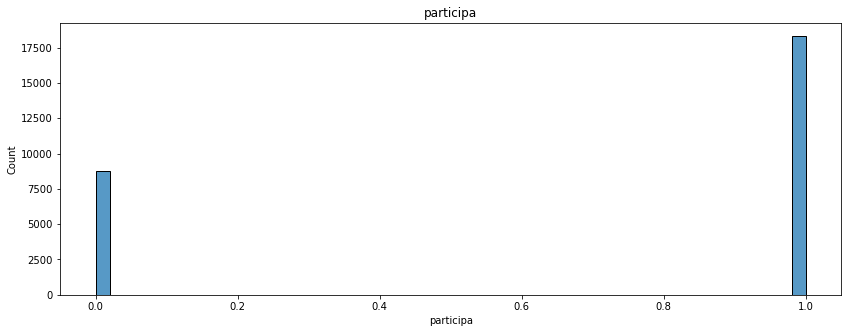

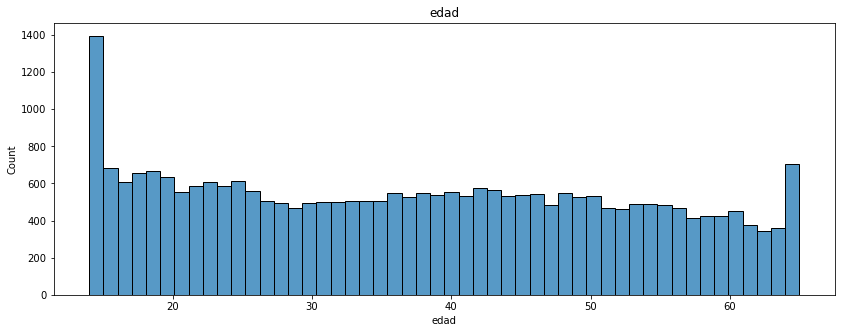

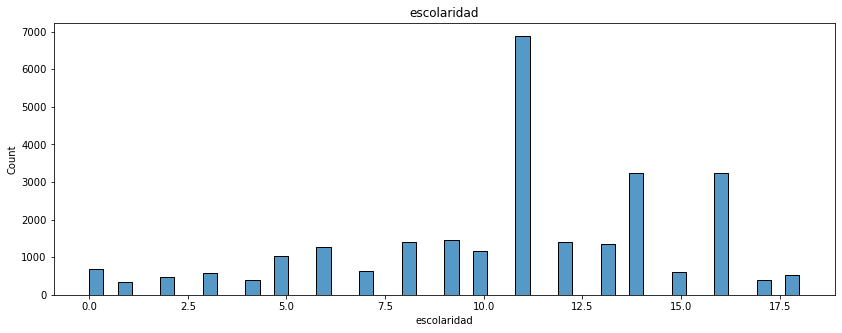

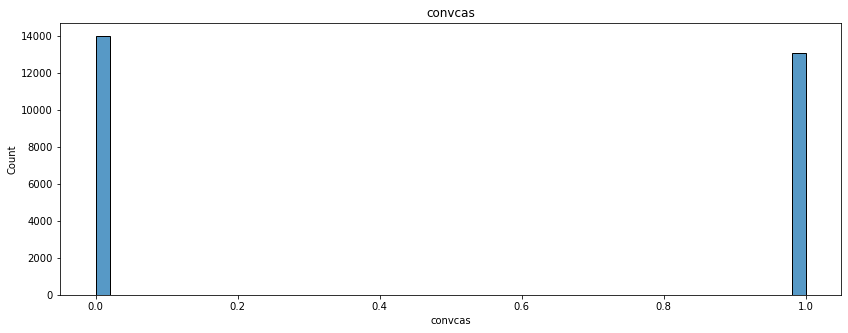

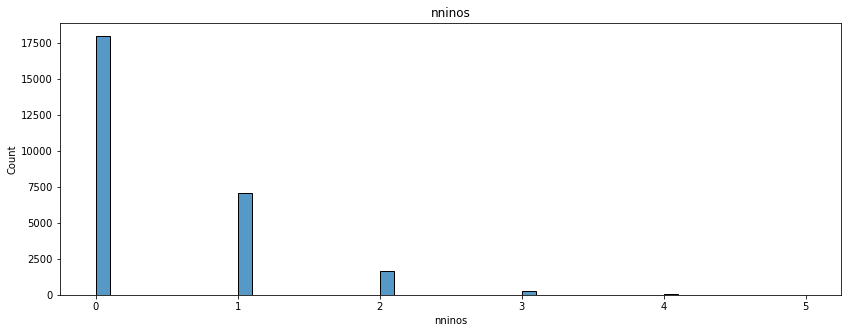

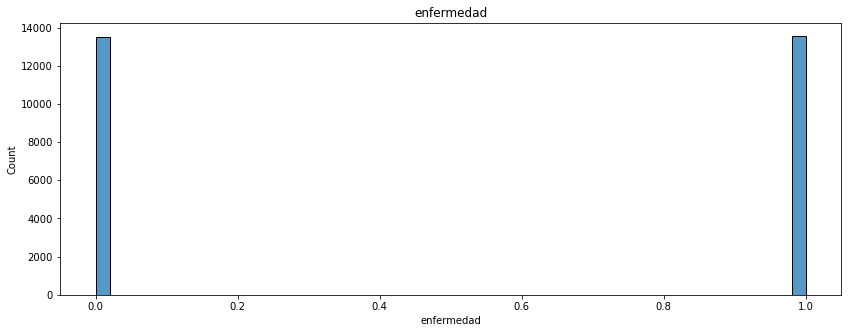

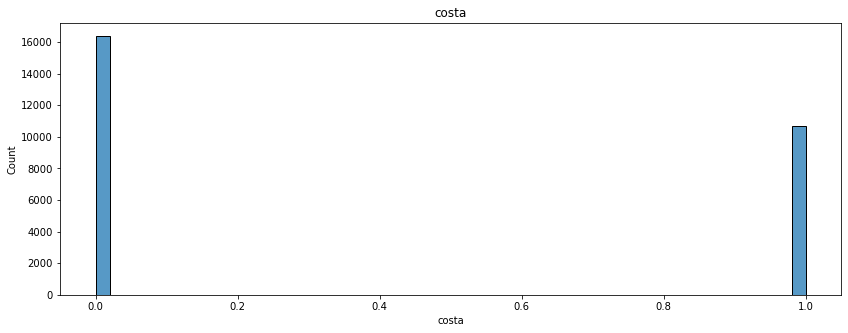

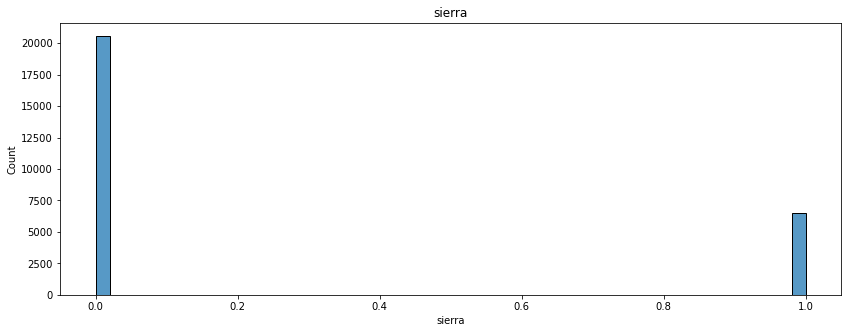

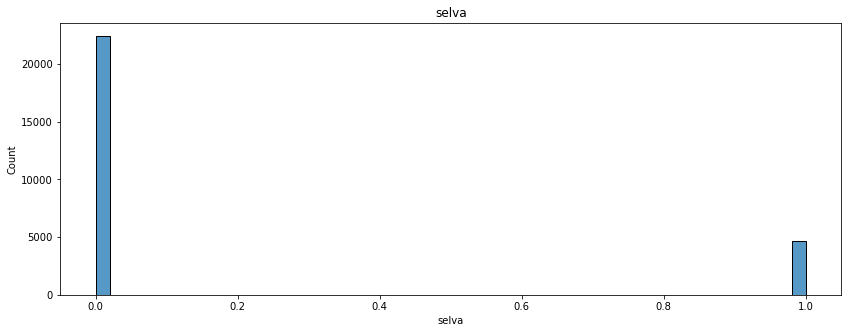

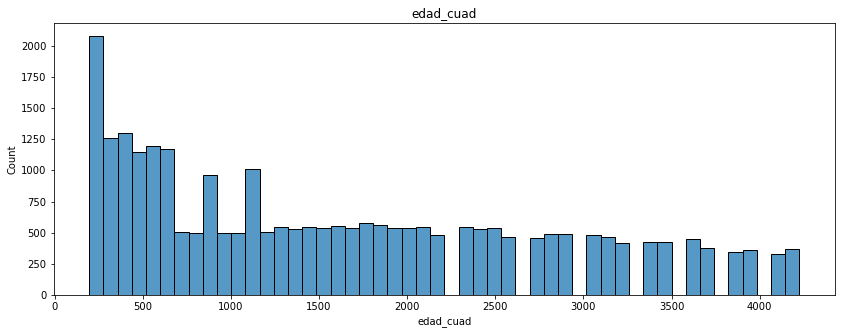

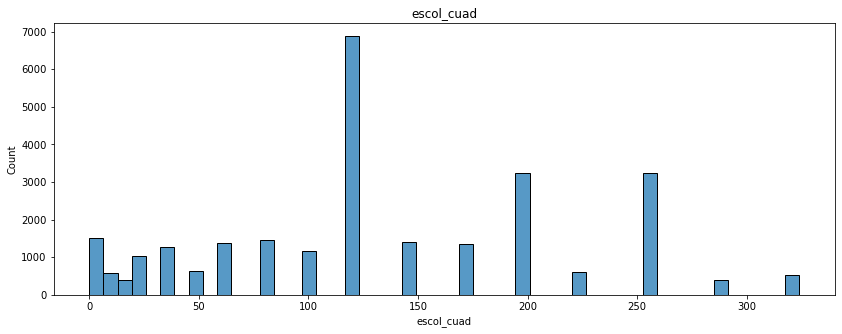

In [12]:
for col in df.columns:
    plt.figure(figsize=(14, 5))
    sns.histplot(data = df, x = col, bins = 50)
    plt.title(col)
    plt.show()


# Análisis multivariado

### Matriz de Correlación

Text(0.5, 1.0, 'Correlation Heatmap')

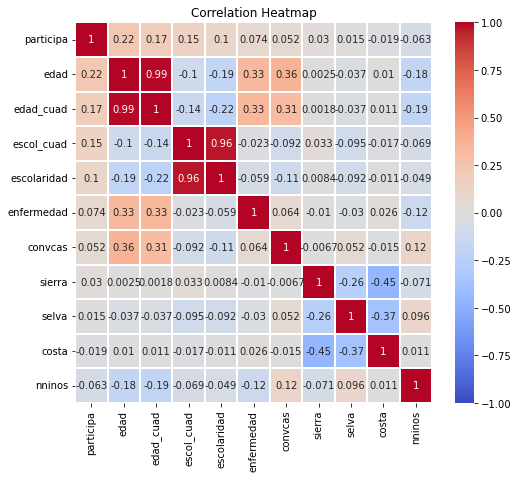

In [13]:
# Ordenando variables de mayor a menor importancia

k = 20   # k : number of variables for heatmap

corrmat = df.corr() 
  
cols = corrmat.nlargest(k, 'participa')['participa'].index
  
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize =(8, 7))
  
my_heatmap = sns.heatmap(cm, vmin=-1, vmax=1, ax = ax, annot=True, cmap ="coolwarm", linewidths = 0.1, yticklabels = cols.values, xticklabels = cols.values)
my_heatmap.set_title('Correlation Heatmap')

####  ANÁLISIS  ####
# la matriz de correlación muestra que la variable más importante para conocer una variación positiva de la participación laboral femenina es la edad de la mujer.
# Por el contratio la variable con correlación más débil y negativa es la cantidad de niños que tiene la mujer. A más niños, menos participación laboral.
# Recordar que este orden es medido en magnitud. Para ordenarlos según la certaza de que esta magnitud sea significante, ver RandomForestClassifier.

In [14]:
# Grid Correlation Matrix

# cg = sns.clustermap(df.corr(), vmin=-1, vmax=1, cmap ="coolwarm", linewidths = 0.1)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)

In [15]:
# alternativa al coeficiente de Pearson que asume una relación lineal de variables, este coeficiente asume una relación monotónica.
stats.spearmanr(df["participa"], df["edad"])

SpearmanrResult(correlation=0.2371193712878805, pvalue=0.0)

# Separación de muestra

In [16]:
X = df.drop('participa', axis=1)  
y = df['participa']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=4, stratify=y)
        # stratify=y : mantiene la proporción de los datos población en las particiones train y test

In [17]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (21659, 10) (21659,)
Test set: (5415, 10) (5415,)


# Balanceo de datos
Se realiza balanceo de datos cuando las clases estan muy desproporcionadas..ya que puede pasar que un modelo sobreaprenda de una clase y no de la otra, lo cual es una deficiencia del modelo ya que la idea es que aprenda a distinguir bien las clases sobre las cuales va a trabajar. Esto ocurre, por ejemplo, si hay muchos 1 y pocos 0 en nuestra muestra.

SMOTE (Técnica de sobremuestreo de Minorías Sintéticas) consiste en la síntesis de elementos para la clase minoritaria, basados en los que ya existen. Funciona eligiendo al azar un punto de la clase minoritaria y calcula los k vecinos más cercanos para este punto. Los puntos sintéticos se agregan entre el punto elegido y sus vecinos.

In [18]:
y_train.value_counts()    # la muestra bastante desbalaceada con respecto a la variable categórica

1.0    14657
0.0     7002
Name: participa, dtype: int64

- **método undersampling**: eliminará datos para encontrar un balance
- **método oversampling tradicional**: aumenta la base minoritaria duplicándo observaciones
- **método oversampling SMOTE**: aumenta la base minoritaria con individuos sintéticos con clustering

In [19]:
y_train.value_counts(normalize=True)

1.0    0.676716
0.0    0.323284
Name: participa, dtype: float64

In [20]:
# aplicando método SMOTE #

smote = SMOTE(random_state=20)
X_sm, y_sm = smote.fit_sample(X_train, y_train)   # muestras balanceadas

columns_X = X_train.columns
columns_y = ["participa"]

X_train_balanced = pd.DataFrame(data=X_sm, columns=columns_X)
y_train_balanced = pd.DataFrame(data=y_sm, columns=columns_y)

In [21]:
y_train_balanced["participa"].value_counts()

0.0    14657
1.0    14657
Name: participa, dtype: int64

In [22]:
# renombrando bases balanceadas

X_train_bal = X_train_balanced
y_train_bal = y_train_balanced["participa"]

# Seleccion de variables relevantes
(feature importance)
## RandomForestClassifier


Encontrando las variables más significativas para entender la variación de la endógena "participa"


In [23]:
# Feature Extraction with RFE met hod
model = RandomForestClassifier(max_depth= 8, n_estimators= 50 )
    # Utiliza todas las variables. Modelo de RandomForestClassifier (tipo árbol), se puede utilizar otros modelos como un algoritmo logístico, un modelo de Boosting, etc. 
    # Genera 50 árboles, con 8 niveles, y los pondera para hacer mejores predicciones.

rfe = RFE(model, step=1, n_features_to_select=7)   
    # RFE utiliza el algoritmo RandomForestClassifier para entrenar y escoger las características más relevantes. 
    # Evalúa y elimina variables de una en una (step=1) hasta quedarse con las que sean más relevantes.
    # n_features_to_select=5 : 5 características a escoger (quedarse).
    
fit = rfe.fit(X_train_bal, y_train_bal)

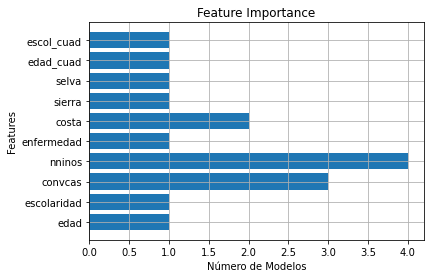

In [24]:
# Graficando horizontal bar plot of feature importance
# Mientras menor sea el número de modelos, serán las mejores variables para nuestro modelo.

pos = np.arange(len(X_train_bal.columns)) + 0.5
plt.barh(pos, fit.ranking_, align='center')
plt.title("Feature Importance")
plt.xlabel("Número de Modelos")
plt.ylabel("Features")
plt.yticks(pos, (X_train_bal.columns))
plt.grid(True)

In [25]:
# quedándonos con las características seleccionadas

features_selected = X_train.columns[fit.support_]     
            # fit.support_ : tiene los índices de las variables que continuan en el modelo 
            # TRUE se quedan, FALSE no se quedan

In [26]:
features_selected

Index(['edad', 'escolaridad', 'enfermedad', 'sierra', 'selva', 'edad_cuad',
       'escol_cuad'],
      dtype='object')

## Entrenamiento y validación de modelos

In [27]:
# Define parámetros que serán usados en los modelos

models = []      # lista que recibirá la etiqueta y el algoritmo

# 4 Modelos analíticos que serán comparados (podemos agregar más)

# creando tuplas ("nombre del modelo", método para el modelo)
models.append(("DecisionTree",   DecisionTreeClassifier (criterion="entropy", max_depth = 10, random_state = 0)))
models.append(("LogRegression",  LogisticRegression     (C=1.0, random_state = 42))) 
models.append(("XGBoost",        XGBClassifier          (colsample_bytree=0.7, learning_rate=0.01, max_depth=6, n_estimators=100, objective= 'binary:logistic', random_state = 42)))
models.append(("R.F.Classifier", RandomForestClassifier (max_depth= 10, max_features='auto', n_estimators= 200, random_state = 42)))

In [28]:
# Evalúa métricas y devuelve métricas involucradas

def eval_metrics(y_test, y_pred, y_prob):
    accuracy  = accuracy_score(y_test, y_pred)
    auc       = roc_auc_score(y_test, y_prob)      # Qué tan bien discrimina el modelo, pero no depende de algún punto de corte
                                                   # Mientras mayor sea el valor auc, mejor será el modelo!!!
    score_f1  = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    
    return (accuracy, auc, score_f1, precision, recall)

In [29]:
models

[('DecisionTree',
  DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)),
 ('LogRegression', LogisticRegression(random_state=42)),
 ('XGBoost',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.7, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, gamma=None,
                gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.01, max_bin=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, predictor=None, random_state=42,
                reg_alpha=None, reg_lambda=None, ...)),
 ('R.F.Classifier',
  RandomForestClassifier(max_depth=10, max_features='au

In [30]:
# # graficando el DecisionTreeClassifier

# classifier = DecisionTreeClassifier (criterion="entropy", max_depth = 8, random_state = 42)
# classifier.fit(X_train_balanced, y_train_balanced)

# featuresNames = list(X_train_balanced.columns)

# plt.rcParams['figure.figsize'] = (400, 350)
# tree.plot_tree(classifier, feature_names = featuresNames, class_names =['0','1'], filled=True, rounded=True)
# plt.savefig("DecisionTreeClassifier_participa.png")
# plt.show()

In [31]:
# entrenando muchos modelos

df_resultados = pd.DataFrame(columns=['Modelo','AUC', 'Accuracy','Score F1', 'Precision', 'Recall'])
threshold = 0.5    # 50% de punto de corte (determinado estadísticamente o por expertice del negocio que puede ser muy conservador o más arriesgado)


_X_train = X_train_bal
_X_test = X_test
_y_train = y_train_bal
_y_test = y_test

for name, model in models:
    model_ = model.fit(_X_train, _y_train)
    
    #Evaluacion del modelo con datos de train
    y_pred = (model_.predict_proba(_X_test)[:,1] >= threshold ).astype(int) 
    y_prob = model_.predict_proba(_X_test)[:, 1] #probability
    (accuracy, auc, score_f1, precision, recall) = eval_metrics(_y_test,y_pred,y_prob) #metrics
    dict_test = {'Modelo': [name], 'AUC': [auc], 'Accuracy': [accuracy], 'Score F1': [score_f1], 'Precision': [precision], 'Recall': [recall]} 
    

    df_res_test = pd.DataFrame(dict_test)
    df_resultados = df_resultados.append(df_res_test, ignore_index = True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [32]:
df_resultados.head()

,Modelo,AUC,Accuracy,Score F1,Precision,Recall
0,DecisionTree,0.705881,0.688643,0.767384,0.776165,0.758799
1,LogRegression,0.680673,0.664820,0.743535,0.771102,0.717872
2,XGBoost,0.722308,0.700646,0.779426,0.777416,0.781446
3,R.F.Classifier,0.728505,0.700462,0.776830,0.783514,0.770259


# Análisis de los resultados
Recordemos que la estrategia radica en encontrar aquel modelo que presente mayor área bajo la curva AUC, pues eso significa que predice mejor la variable objetivo. Entonces, según por el último cuadro, el modelo Random Forest Classifier sería el mejor para predecir la participación de las mujeres en el mercado laboral peruano.

Además, las variables más importantes son la edad, escolaridad, si tienen alguna enfermedad y la región de residencia.